In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import random
from numpy.random import beta
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from sklearn.base import BaseEstimator
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import train_test_split
from scipy import ndimage
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split, check_random_state
from sklearn.utils.validation import _num_samples


In [2]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

def get_data(data, indices=None, binarize=True):
  N = len(data)
  if indices is None:
    indices = range(0, N)
  #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
  X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
  if binarize: X = (X > 0.5)
  #y = torch.tensor([data[i][1] for i in indices])
  y = np.array([data[i][1] for i in indices])
  return X, y

data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    download=True,
    transform=data_transform
)

X, y = get_data(data)

## Task 1: Visualizing the EMNIST Dataset

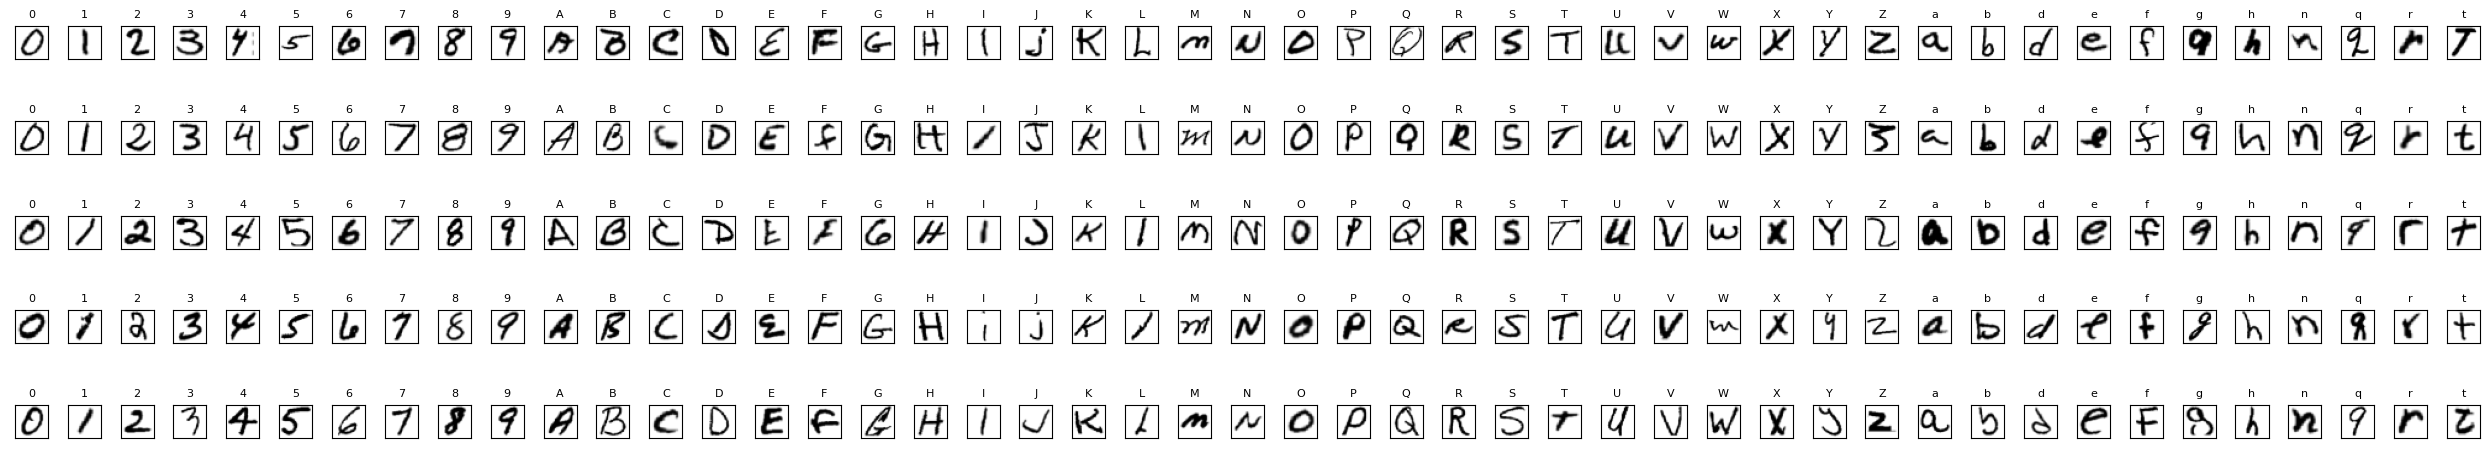

In [3]:
dict = {sample: [] for sample in range(len(np.unique(y)))}
for i in range (len(y)):
  dict[y[i]].append(i)

for key,value in dict.items():
  dict[key]= random.sample(value,5)


cols, rows = len(dict.keys()), 5

figure = plt.figure(figsize=(25, 5))
fig_pos =1 
for value  in range(rows):
  for i in range(cols):
     sample_idx =  dict[i][value]
     img, label = data[sample_idx]
     figure.add_subplot(rows, cols,fig_pos)
     label = data.classes[label]
     plt.title(label, fontsize=8)
     plt.xticks([])
     plt.yticks([])
     plt.imshow(ndimage.rotate(np.flipud(img.squeeze()),270), cmap=plt.cm.binary)
     fig_pos=fig_pos+1

plt.tight_layout()
plt.show()

In [4]:
def graph_plot(estimator, label, X, y, axes=None, ymax=None,n_jobs=None,cv=None):
    common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv":cv,
    "n_jobs": n_jobs,
    "return_times": True,
    }
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(25, 5)) 
    axes[0].set_title(label)
    if ymax is not None:
        axes[0].set_ylim(*ymax)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
   
    train_count, train_scores, test_scores, time_to_fit, _ = learning_curve(
    estimator, **common_params)
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    fit_mean = np.mean(time_to_fit, axis=1)

    axes[0].grid()
    axes[0].plot(train_count, train_mean, color="b",label="Training")
    axes[0].plot(train_count, test_mean, color="r",label="Cross-validation") 
    axes[0].legend(loc="best")
    axes[1].grid()
    axes[1].plot(train_count, fit_mean,color = 'g') 
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("time_to_fit")
    axes[1].set_title("Scalability")
    axes[2].grid()
    axes[2].plot(fit_mean, test_mean,color = 'b')
    axes[2].set_xlabel("time_to_fit") 
    axes[2].set_ylabel("Score") 
    axes[2].set_title("Performance")
    return plt

In [5]:
def graph_plot_imbalance(estimator, label, X, y, n_jobs=None, cv=None, index=None, axes=None):
    common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv":cv,
    "n_jobs": n_jobs,
    "return_times": True,
    }
    train_count, train_scores, test_scores, time_to_fit, _ = learning_curve(estimator, **common_params)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    fit_mean = np.mean(time_to_fit, axis=1)
    
    axes[index].grid()
    axes[index].set_title(label)
    axes[index].plot(train_count, train_mean, color="b", label="Training")
    axes[index].plot(train_count, test_mean, color="r", label="Cross-validation")
    axes[index].legend(loc="best")
    axes[index].set_xlabel("Training examples")
    axes[index].set_ylabel("score")

In [7]:
class CustomShuffleSplit(BaseShuffleSplit):
    def __init__(self, n_splits=10, *, test_size=None, train_size=None, random_state=None, y=None, alpha_class=None):
        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state,
        )
        self._default_test_size = 0.1
        self._y = y
        self.alpha_class = alpha_class  # Store alpha_class as an instance variable

    def _imbalanced_sampling(self, train_indices, y):
        # Use self.alpha_class to access the instance variable
        alpha_class = self.alpha_class
        y_train = y[train_indices]
        class_freq_dict = Counter(y_train)
        dist = (np.random.dirichlet([alpha_class] * 47 , 1)*train_indices.shape[0]).astype(int).flatten()
        dist[dist == 0] = np.random.choice([1, 2, 3])
        for index, item in enumerate(dist):
            if dist[index] > class_freq_dict[index]:
                dist[index] = class_freq_dict[index]
        label_index_dict = {}
        for index, label in enumerate(y_train):
            label_index_dict[label] = label_index_dict.get(label, []) + [index]
        sampled_indices = []
        for label, num_samples in enumerate(dist):
            sampled_indices.extend(random.sample(label_index_dict[label], num_samples))
        return sampled_indices

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples,
            self.test_size,
            self.train_size,
            default_test_size=self._default_test_size,
        )

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test : (n_test + n_train)]

            ind_train = self._imbalanced_sampling(ind_train, y)

            yield ind_train, ind_test

### Task2.1, Task2.2, Task 2.3: Building a Model- MLE

In [6]:
class MLE(BaseEstimator):
    def __init__(self, classes=47):
        self.classes = classes
        self.num_pixels = 28
        self.pixel_probab = [] 
        self.class_prior = []
        self.pseudo_count = 1e-12
        self.probs = []

    def fit(self, X, y):
        self.class_prior = [Counter(y)[i]/len(y) for i in range(self.classes)]
        for c in range(self.classes):
          temp = np.zeros((self.num_pixels, self.num_pixels))
          sample_index = (y == c)
          X_type = X[sample_index]
          for i in range(len(X_type)):
             temp += X_type[i]
          temp = temp/len(X_type)
          self.pixel_probab.append(temp)

    def predict(self, X):
        y_pred =[]
        for i in range(len(X)):
            class_scores = []
            image = X[i]
            for c in range(self.classes):
                means = self.pixel_probab[c] 
                # print(means)
                prob_est = 0
                class_scores, temp = self.get_probabilities(image, class_scores,means,prob_est,c)
            y_pred.append(np.argmax(class_scores)) 
        return y_pred
    
    def get_probabilities(self, image, class_scores, means, prob_est, c):
        image_array = np.array(image)
        means_array = np.array(means)
        prob_est += np.sum(image_array * np.log(means_array + self.pseudo_count) + (1 - image_array) * np.log(1 - means_array + self.pseudo_count))
        posterior = prob_est + np.log(self.class_prior[c])
        class_scores.append(posterior)
        return class_scores, prob_est

    def score(self, X,y):
        log_likelihood = []
        for i in range(len(X)):
            class_scores = []
            c = y[i]
            image = X[i]
            means =self.pixel_probab[c]
            class_scores, probab_est = self.get_probabilities(image, class_scores,means,log_likelihood,c)
            log_likelihood= np.sum(probab_est)
        dataset_size = len(X)
        score = log_likelihood / dataset_size
        return score

##  Plotting the Learning Curves for (almost) Balanced Training Data (MLE)

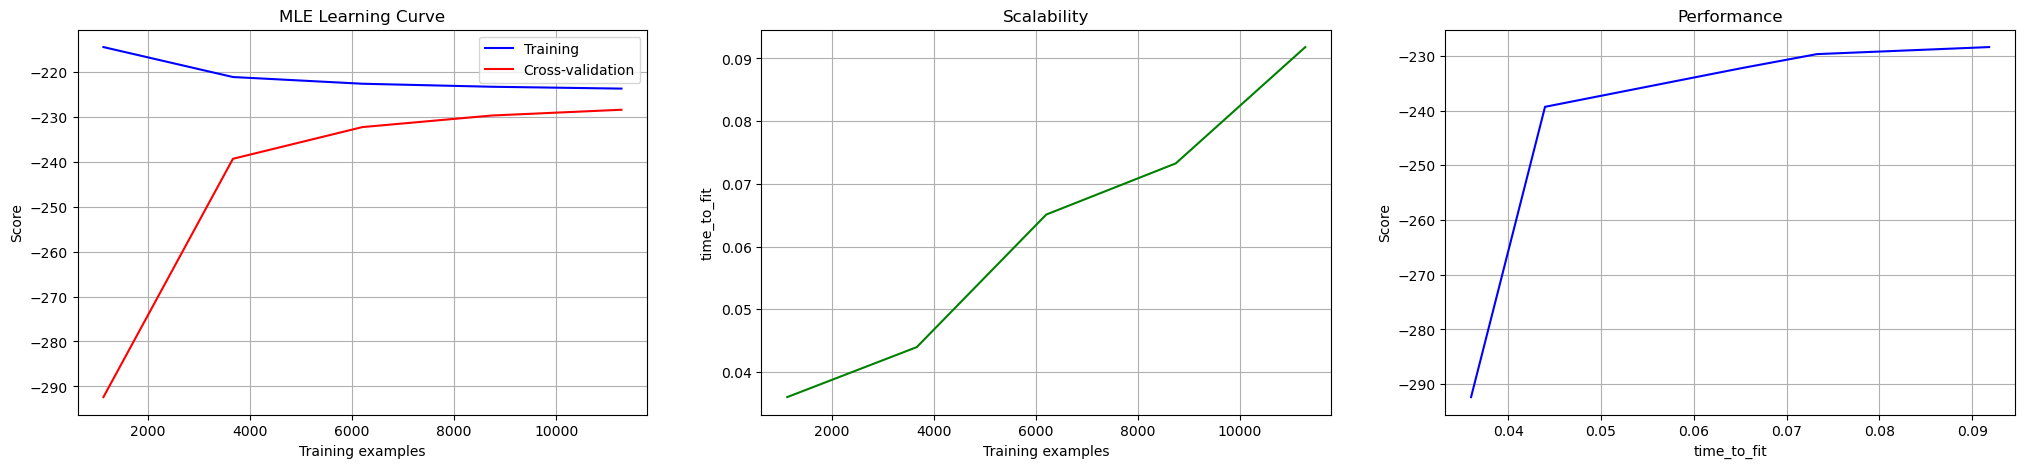

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.90, random_state=0)
mle = MLE()
mle.fit(X_train, y_train)
mle.predict(X_train)
cv = ShuffleSplit(n_splits=12,test_size=0.90,random_state=0)
plt = graph_plot(mle, 'MLE Learning Curve', X, y, n_jobs=1,cv=cv)
plt.show()

### Task2.1, Task2.2, Task 2.3: Building a Model - MAP

In [12]:
class MAP(BaseEstimator):
    def __init__(self, alpha, beta, classes=47):
        self.classes = classes
        self.num_pixels = 28
        self.alpha = alpha
        self.beta =beta
        self.pixel_probab = [] 
        self.class_prior =[]
        self.dist=[]
        self.pseudo_count = 1e-12
        self.probs = []
    
    def fit(self, X, y):
        self.dist=[Counter(y)[i]/len(y) for i in range(self.classes)]
        # print(self.dist)
        alpha_1= self.generate_alphas()
        self.class_prior =self.mode(alpha_1)
        # print(self.class_prior)

        for c in range(self.classes):
          
          ones = np.zeros((self.num_pixels, self.num_pixels))
          sample_index = (y == c)
          X_type = X[sample_index]
          for i in range(len(X_type)):
             ones += X_type[i]
          zeros = len(X_type) - ones 
          self.pixel_probab.append(self.nums(ones,zeros))
        # print(self.pixel_probab)
    
    def nums(self,ones,zeros):
        a, b = self.beta
        n = zeros+b
        m = ones+a
        pixel_probab = (m - 1)/(m + n - 2)
        return pixel_probab
    

    def generate_alphas(self, alpha=None):
        if alpha is None:
           alpha = self.alpha
        return np.add(self.alpha,self.dist)
    
    def mode(self, alpha):
      return ((alpha - 1) / (sum(alpha) - self.classes))

    def predict(self, X):
        y_pred =[]
        for i in range(len(X)):
            class_scores = []
            image = X[i]
            for c in range(self.classes):
                means = self.pixel_probab[c] 
                prob_est = 0
                class_scores, temp = self.get_probabilities(image, class_scores,means,prob_est,c)
            y_pred.append(np.argmax(class_scores)) 
        return y_pred

    def get_probabilities(self, image, class_scores, means, prob_est, c):
        image_array = np.array(image)
        means_array = np.array(means)
        prob_est += np.sum(image_array * np.log(means_array + self.pseudo_count) + (1 - image_array) * np.log(1 - means_array + self.pseudo_count))
        posterior = prob_est + np.log(self.class_prior[c])
        class_scores.append(posterior)
        return class_scores, prob_est

    def score(self, X,y):
        log_likelihood = []
        for i in range(len(X)):
            class_scores = []
            c = y[i]
            image = X[i]
            # log_likelihood += np.log(self.class_prior[c])
            means =self.pixel_probab[c]
            class_scores, probab_est = self.get_probabilities(image, class_scores,means,log_likelihood,c)
            log_likelihood= np.sum(probab_est)
        dataset_size = len(X)
        score = log_likelihood / dataset_size
        return score

## Plotting the Learning Curves for (almost) Balanced Training Data (MAP)    
### [alpha=1, beta=1]

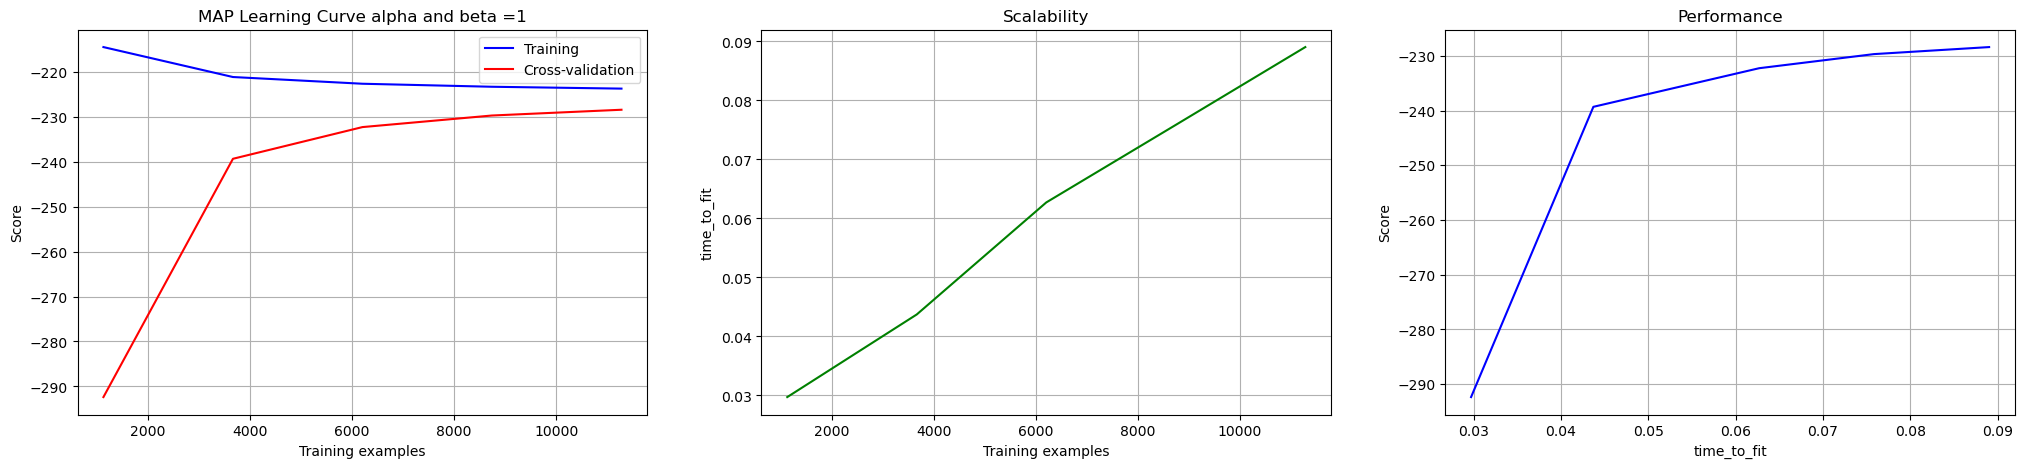

In [10]:
map = MAP(alpha=[1] * 47, beta=[1, 1])
map.fit(X_train, y_train)
map.predict(X_train)
cv = ShuffleSplit(n_splits=12,test_size=0.90,random_state=0)
plt = graph_plot(map, 'MAP Learning Curve alpha and beta =1', X, y, n_jobs=1,cv=cv)
plt.show()

## Task 3.1: Plotting the Learning Curves for (almost) Balanced Training Data (MAP)        
### [Beta = 1, alpha =(1, 10, 50, 100, 200)]

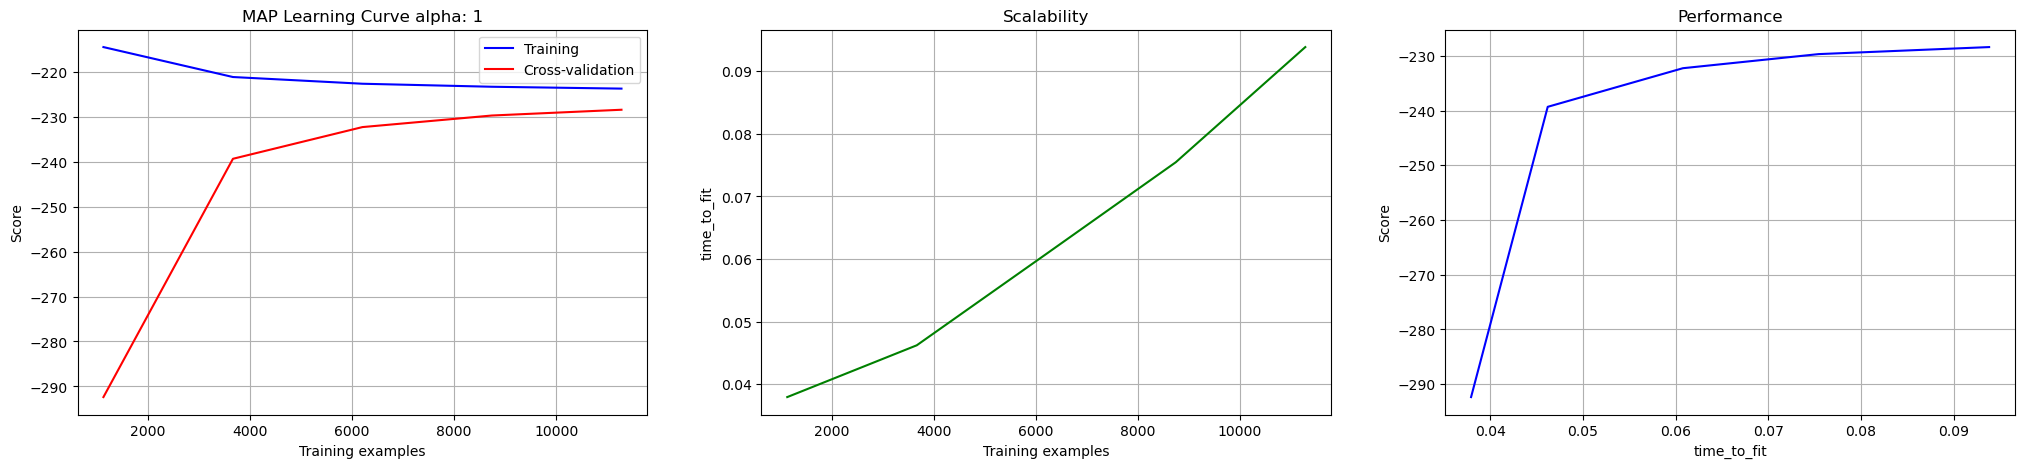

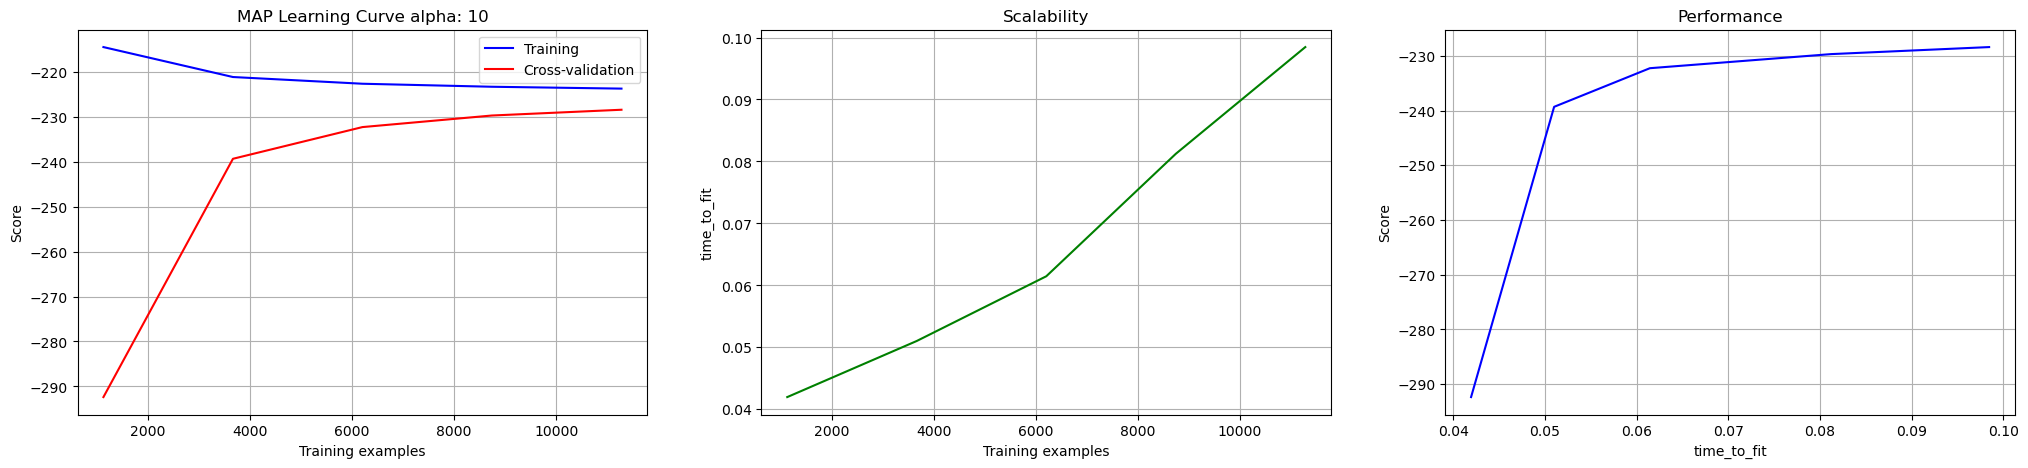

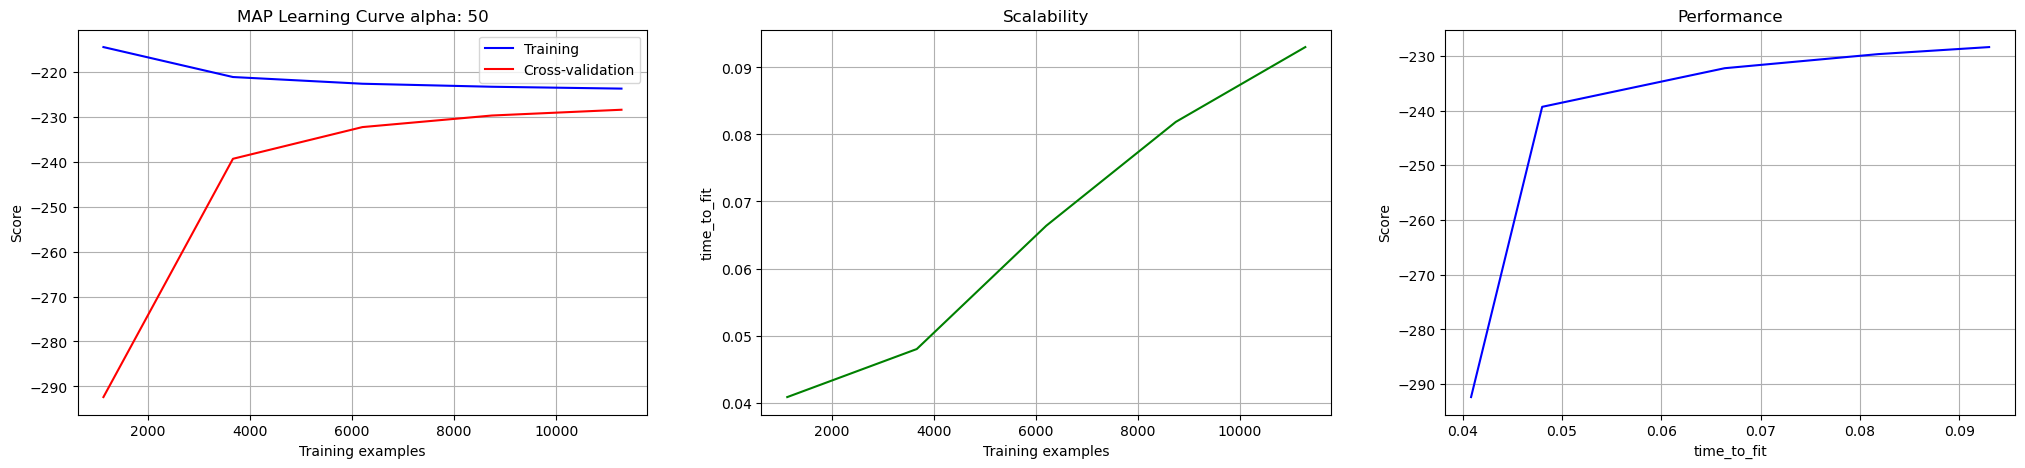

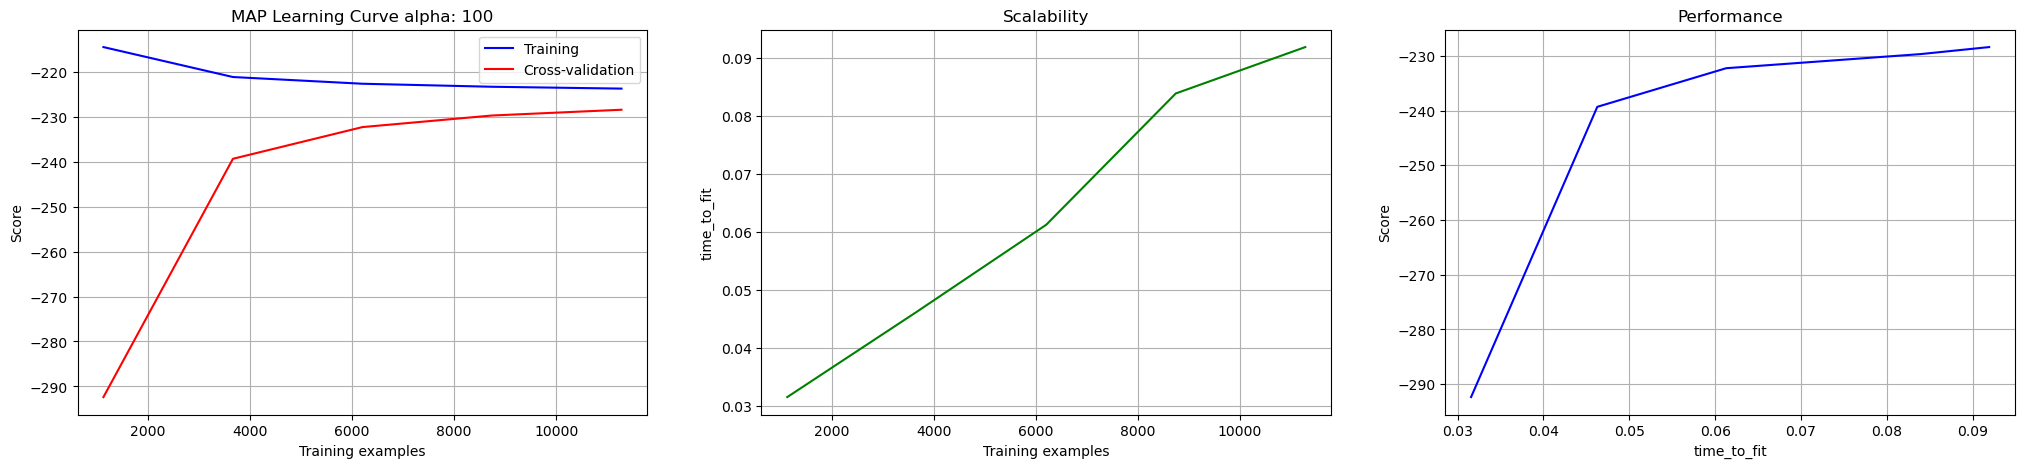

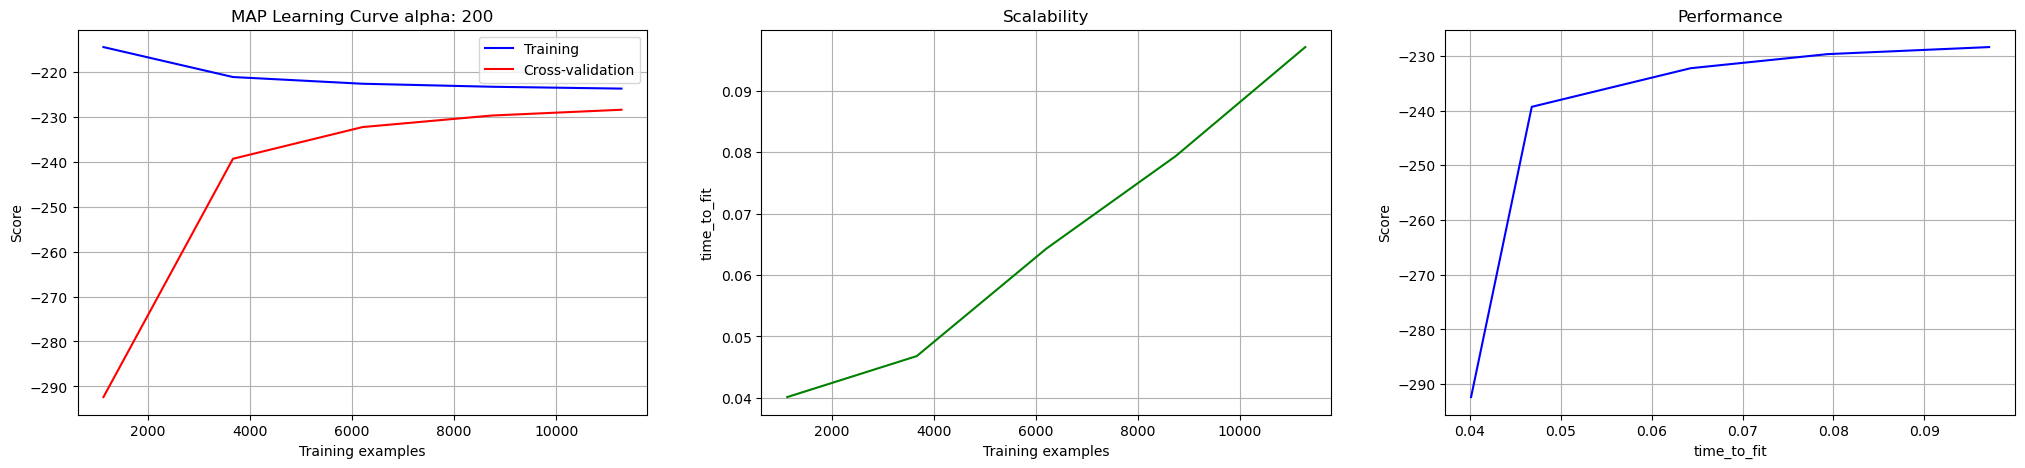

In [13]:
for a in (1, 10, 50, 100, 200):
    map = MAP(alpha=[a] * 47, beta=[1, 1])
    map.fit(X_train, y_train)
    map.predict(X_train)
    cv = ShuffleSplit(n_splits=12,test_size=0.9,random_state=0)
    plt = graph_plot(map, f'MAP Learning Curve alpha: {a}', X, y, n_jobs=1,cv=cv)
    plt.show()

## Task 3.2: Plotting the Learning Curves for (almost) Balanced Training Data (MAP) 
### [alpha = 1, beta =(1, 2, 10, 100)]

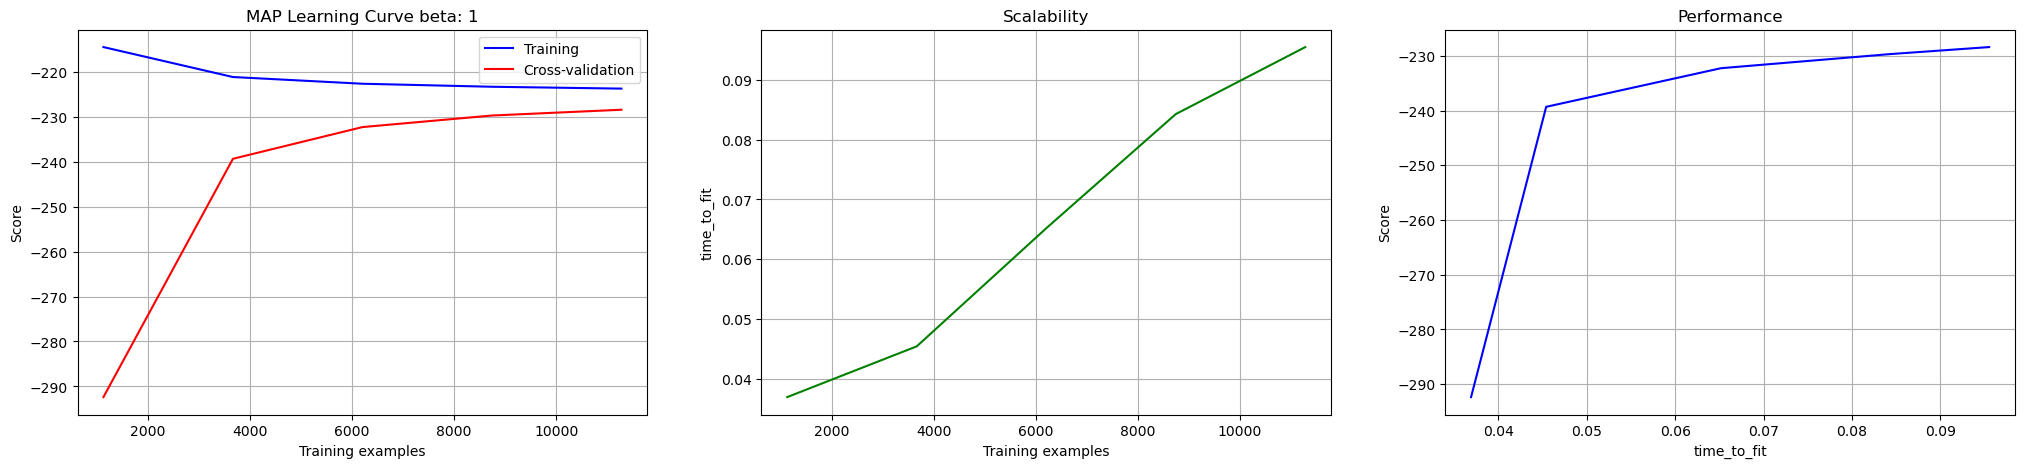

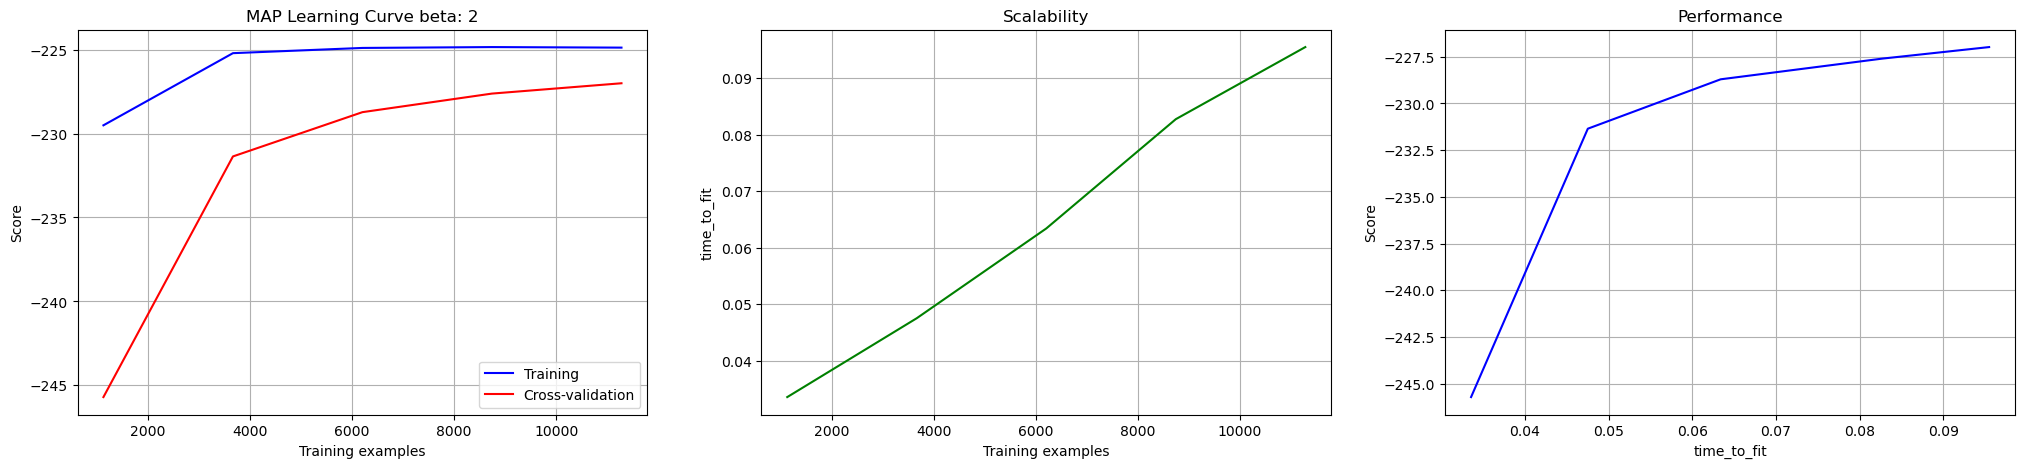

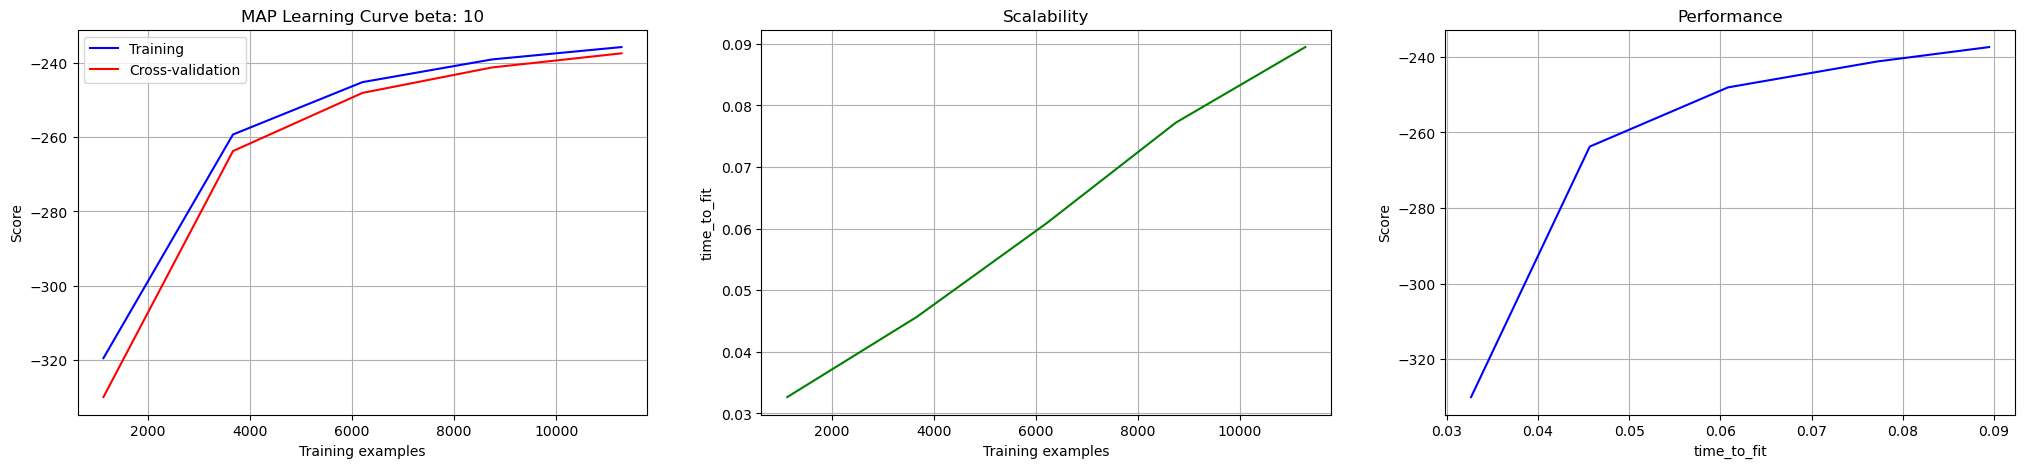

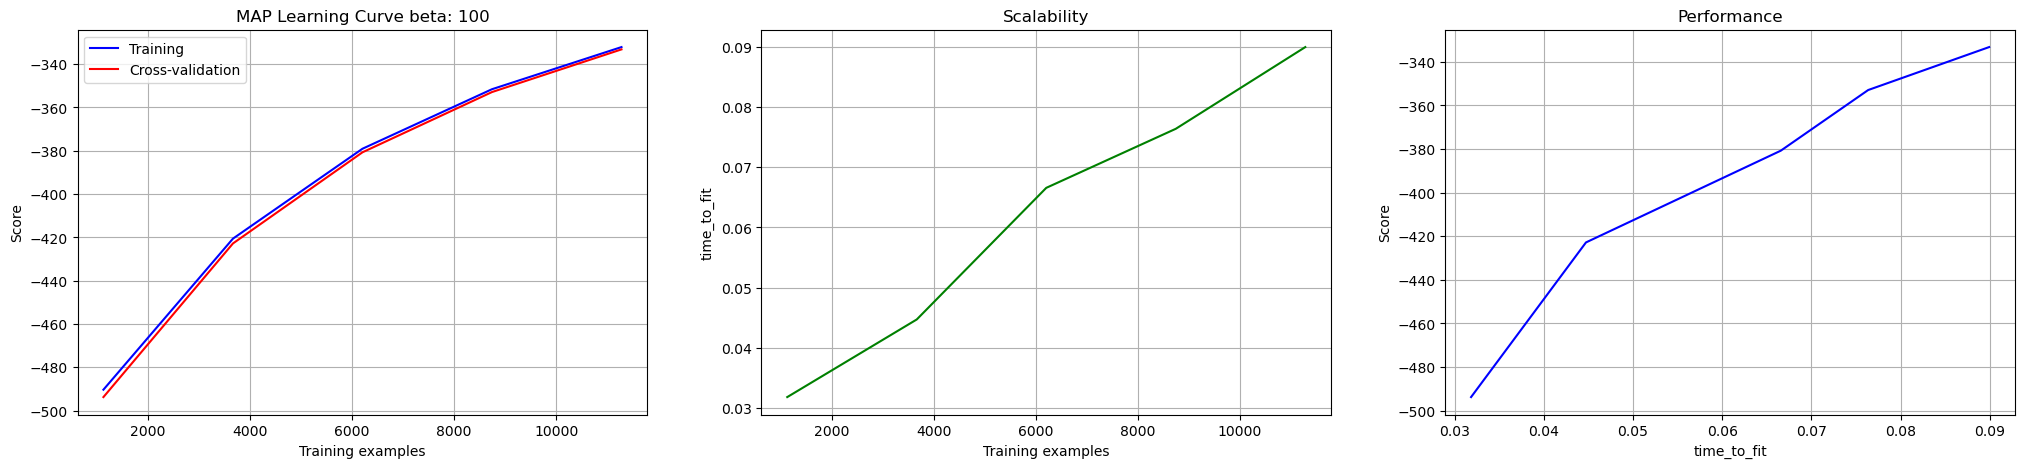

In [14]:
for b in (1, 2, 10, 100):
    map = MAP(alpha=[1] * 47, beta=[b, b])
    map.fit(X_train, y_train)
    map.predict(X_train)
    cv = ShuffleSplit(n_splits=12,test_size=0.9,random_state=0)
    plt = graph_plot(map, f'MAP Learning Curve beta: {b}', X, y, n_jobs=1,cv=cv)
    plt.show()

## Plotting the Learning Curves for Imbalanced Training Data (MLE)    
### 𝛼class = (0.1, 0.2, 0.5, 1, 10, 100).

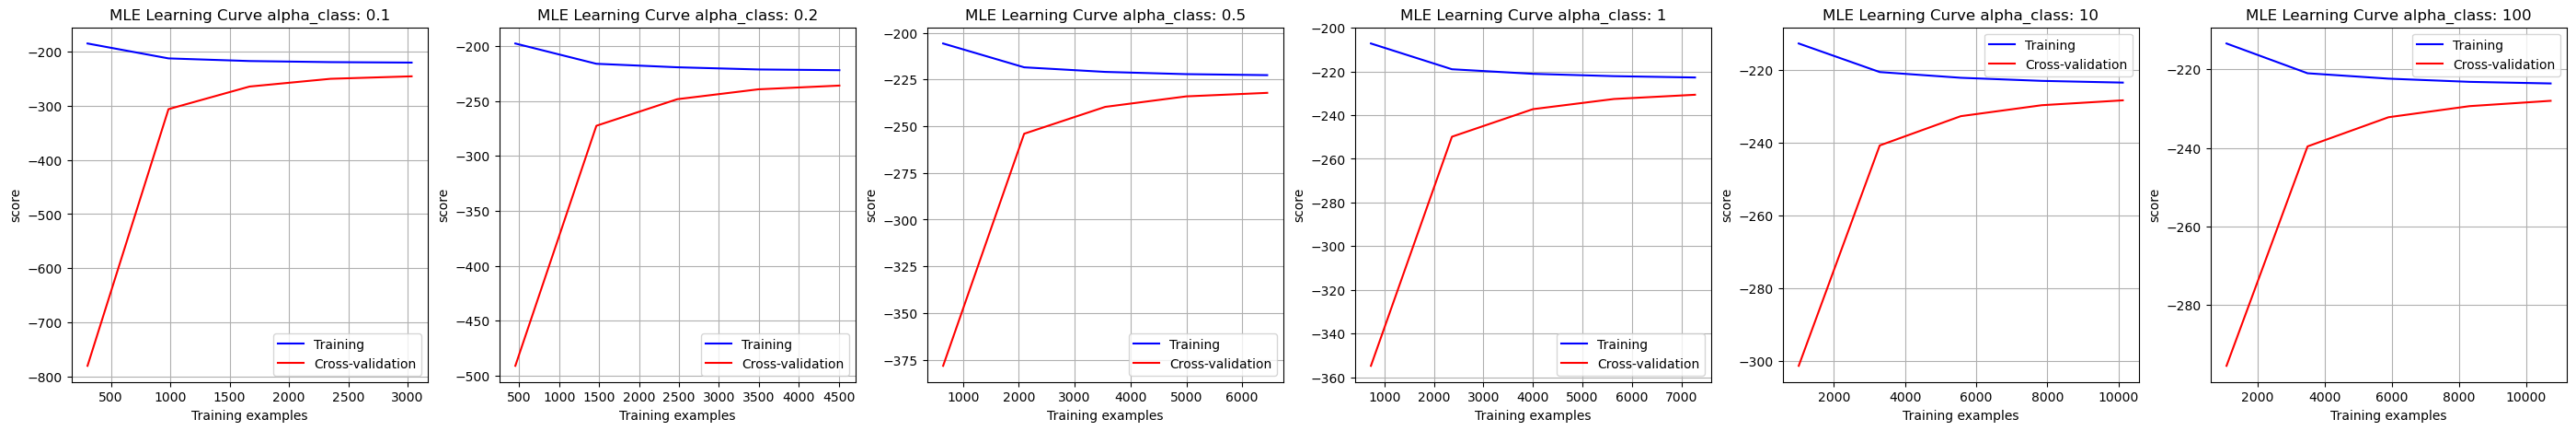

In [ ]:
alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
fig, axes = plt.subplots(1, 6, figsize=(35, 5))
axes = axes.ravel()
mle = MLE()
mle.fit(X_train, y_train)
mle.predict(X_train)
for i, a_c in enumerate(alpha_class):
    cv = CustomShuffleSplit(n_splits=12, test_size=0.9, random_state=0, y=y, alpha_class=a_c)
    graph_plot_imbalance(mle, f'MLE Learning Curve alpha_class: {a_c}', X, y, n_jobs=-1, cv=cv, index=i,axes=axes)
plt.show()

## Task 4.2: Plotting the Learning Curves for Imbalanced Training Data (MAP)   
### pixel prior 𝛽 = 1 and try 𝛼 = (1, 10, 100, 1000) for 𝛼class = (0.1, 0.2, 0.5, 1, 10, 100).


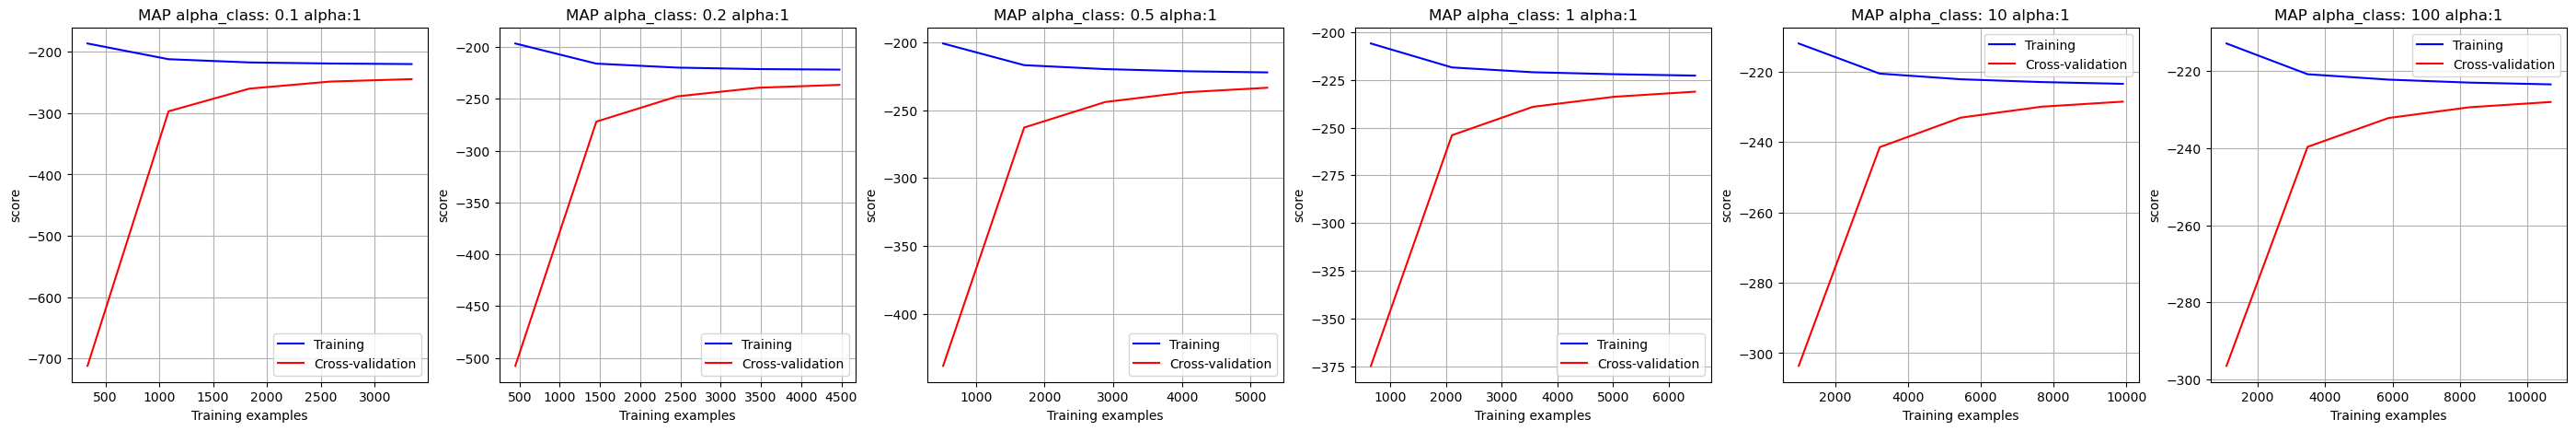

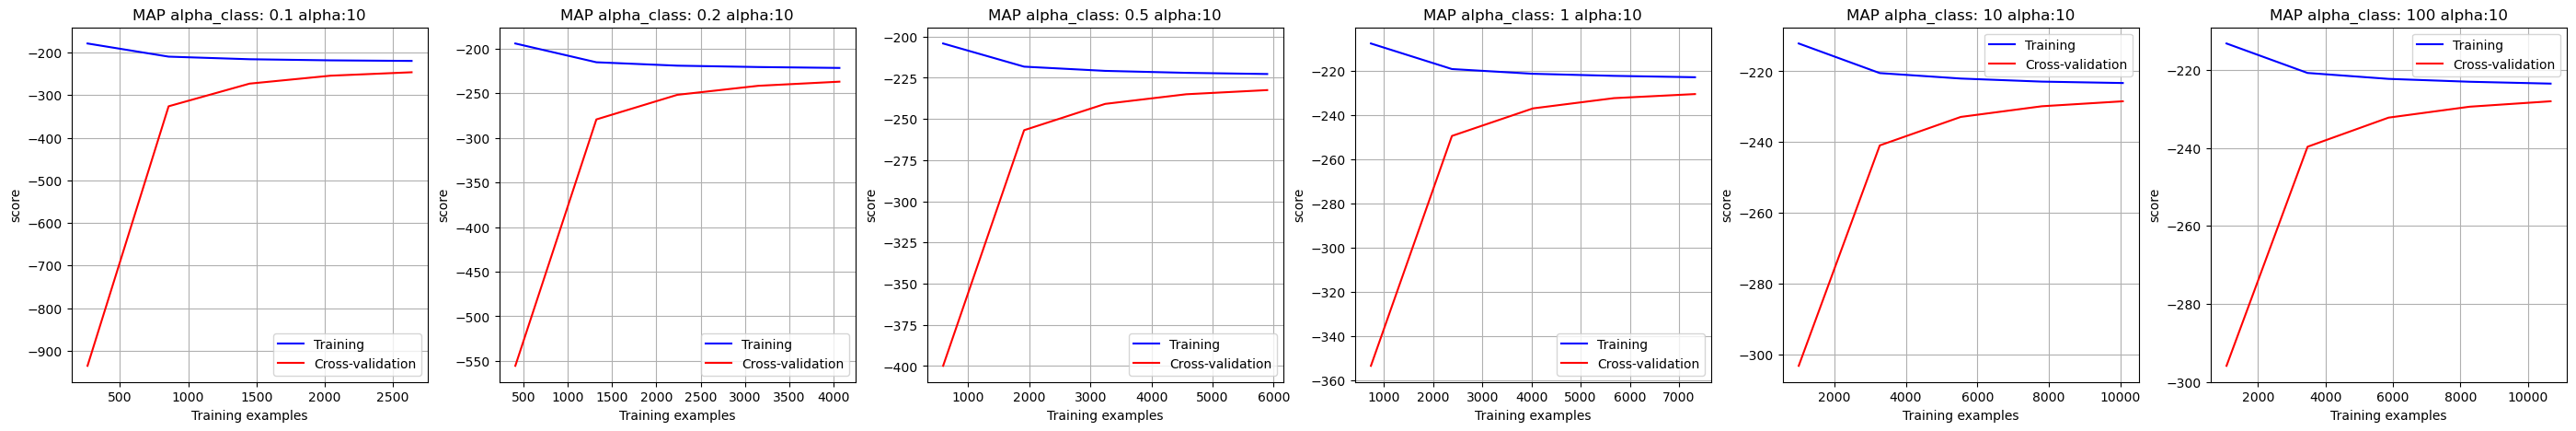

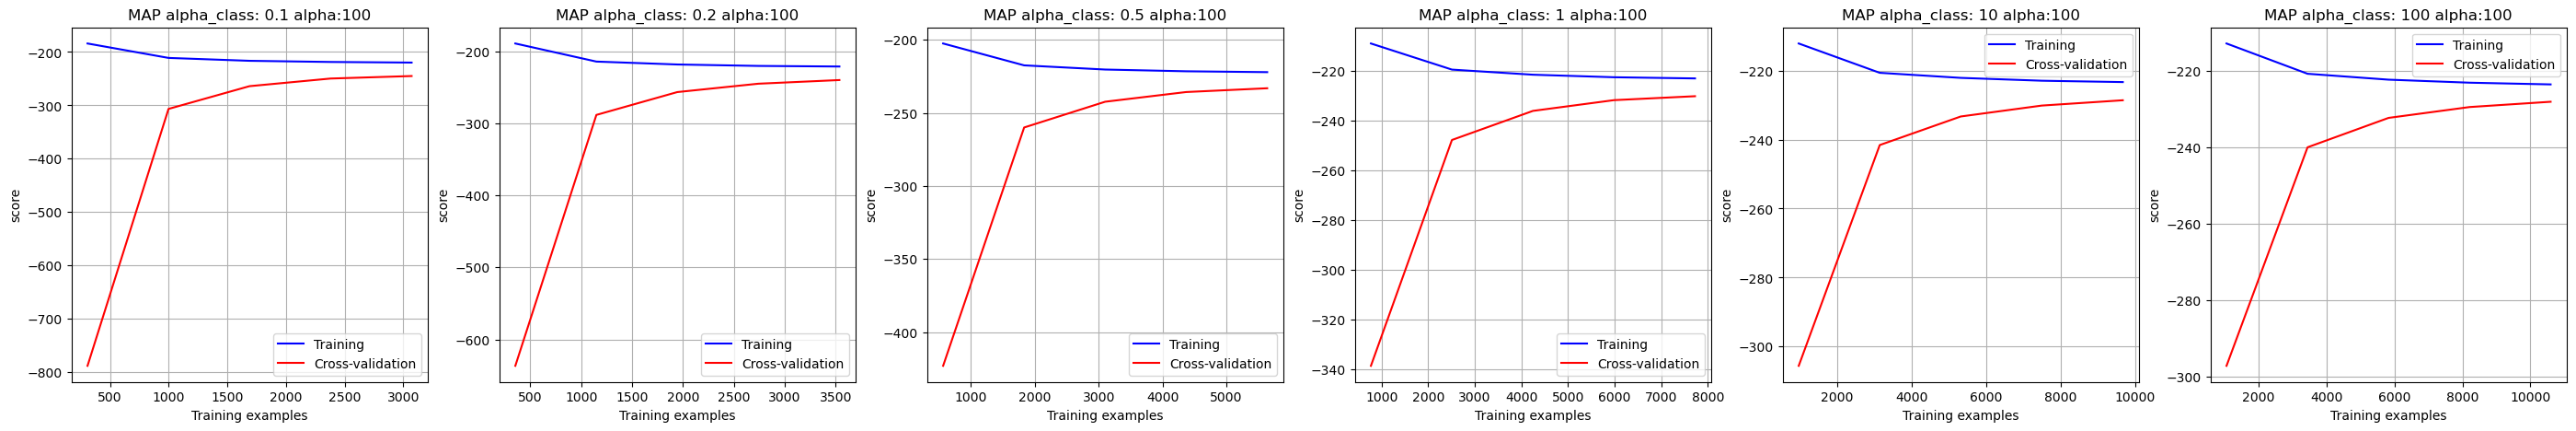

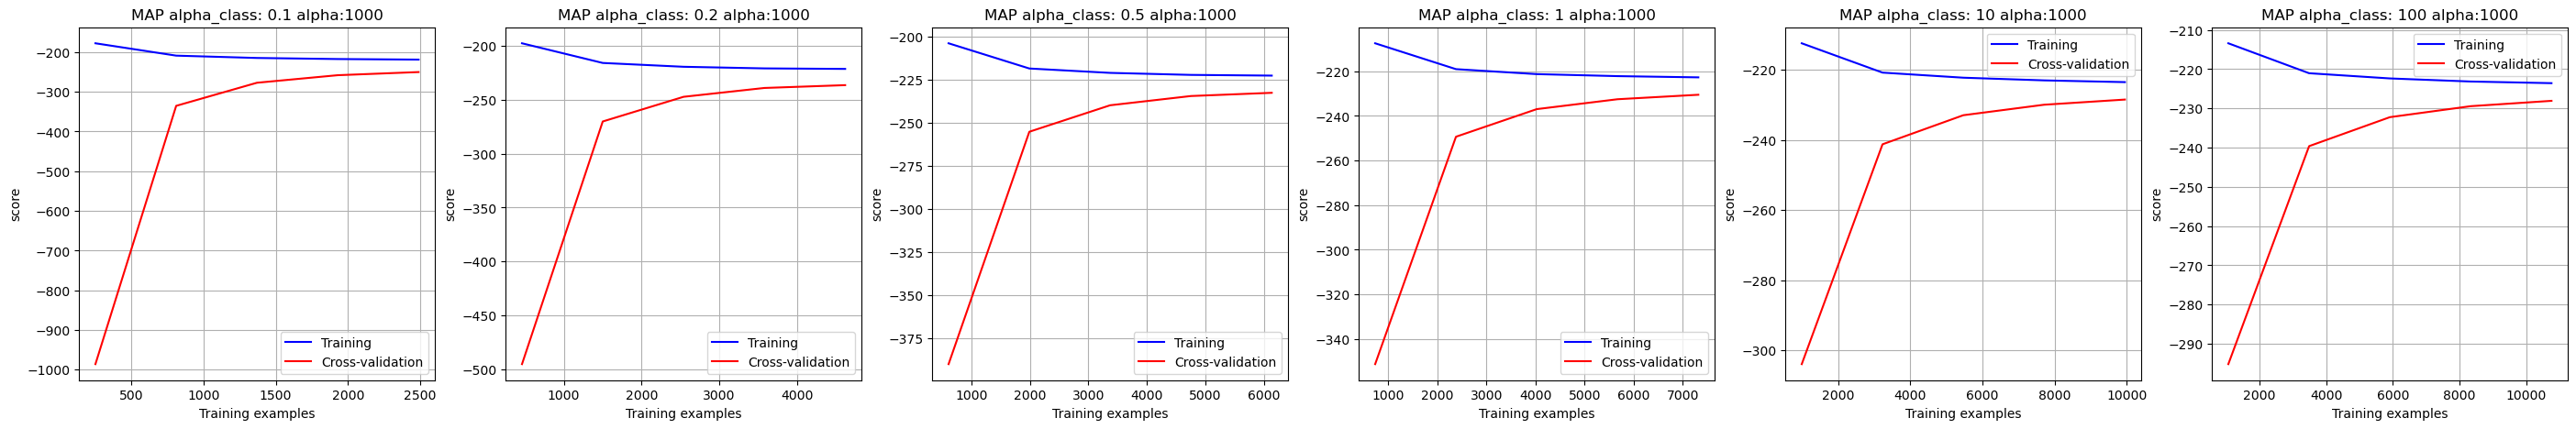

In [ ]:

alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
alphas = [1, 10, 100, 1000]
for i,a in enumerate(alphas):
    
    fig, axes = plt.subplots(1, 6, figsize=(35, 5))
    axes = axes.ravel()
    for index, a_c in enumerate(alpha_class):
        data = datasets.EMNIST(
            root="~/data",
            split="balanced",
            download=True,
            transform=data_transform
        )
        X, y = get_data(data)
        cv = CustomShuffleSplit(n_splits=12, test_size=0.9, random_state=0, y=y, alpha_class=a_c)
        graph_plot_imbalance(MAP(alpha=[a] * 47, beta=[1, 1]), f'MAP alpha_class: {a_c} alpha:{a}', X, y, n_jobs=-1, cv=cv, index=index,axes=axes)
    plt.show()

## Task 4.1:Plotting the Learning Curves for Imbalanced Training Data (MAP)  
### class prior 𝛼 = 1 and try 𝛽 = (1, 1.2, 2, 10, 100) for 𝛼class = (0.1, 0.2, 0.5, 1, 10, 100).


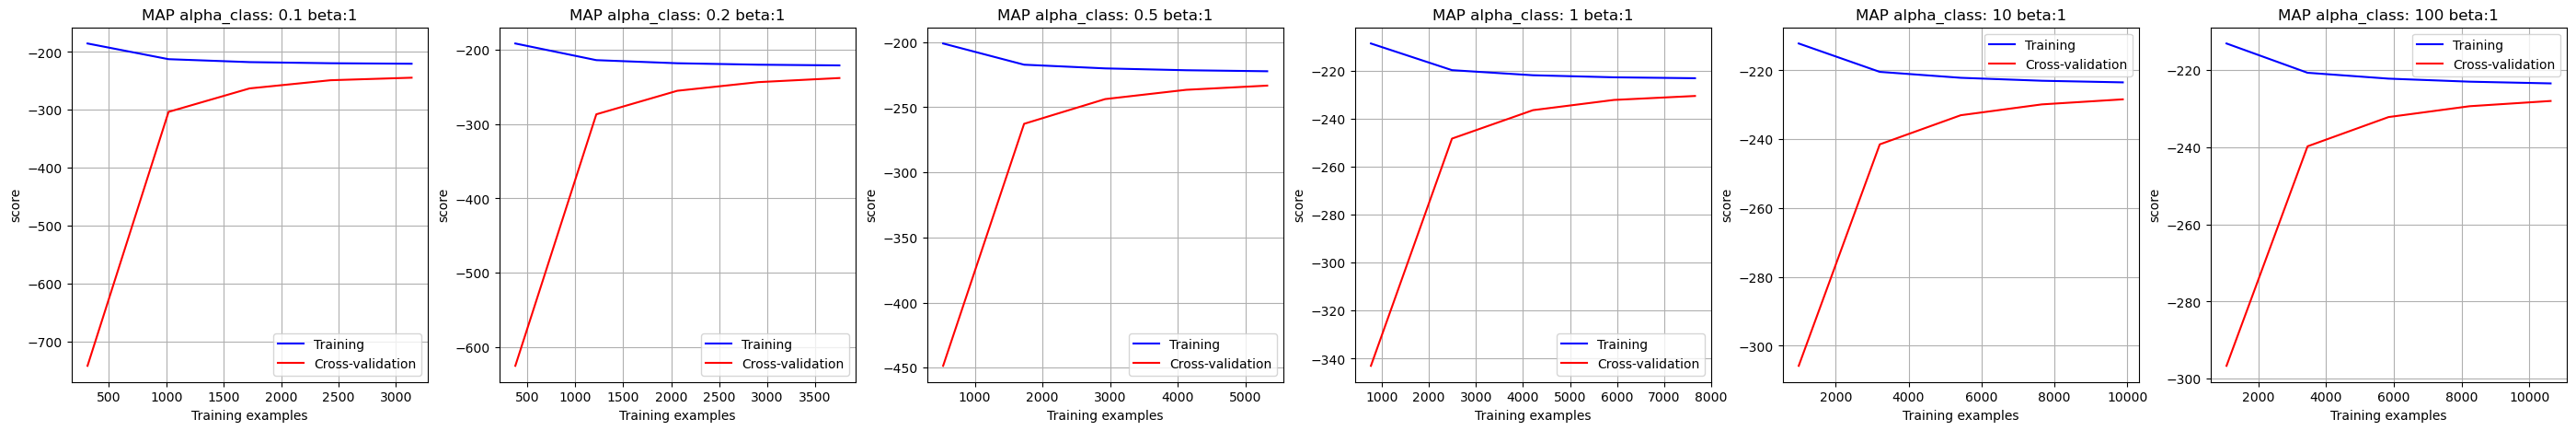

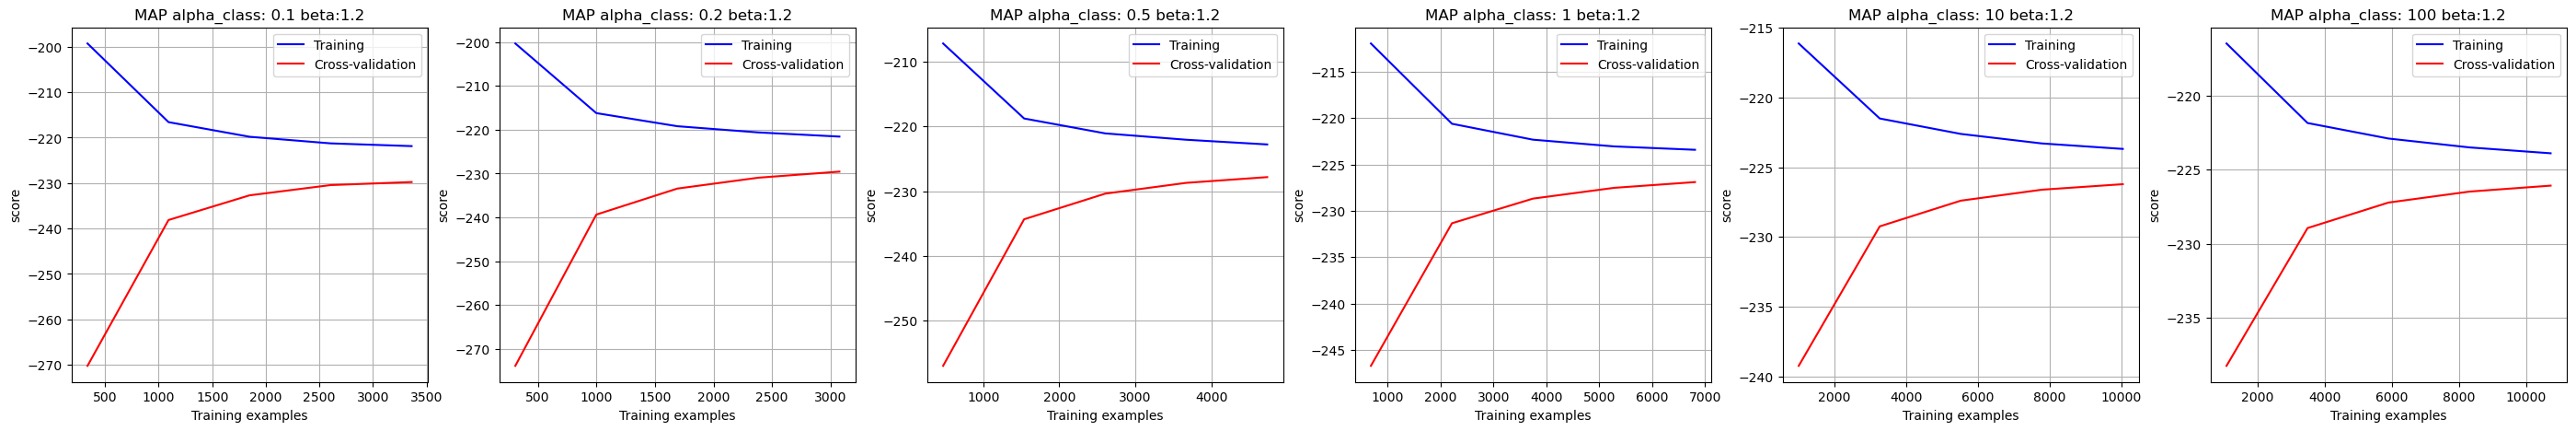

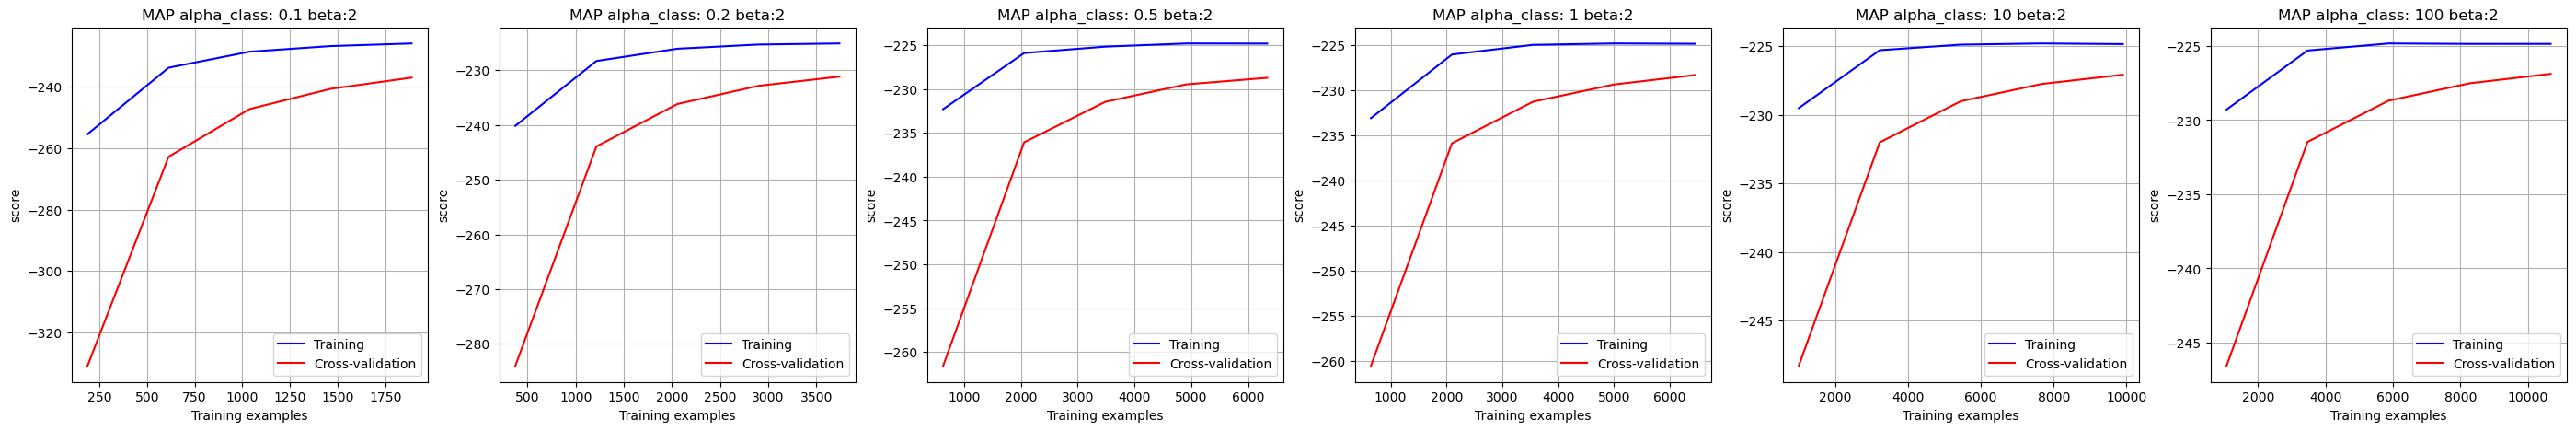

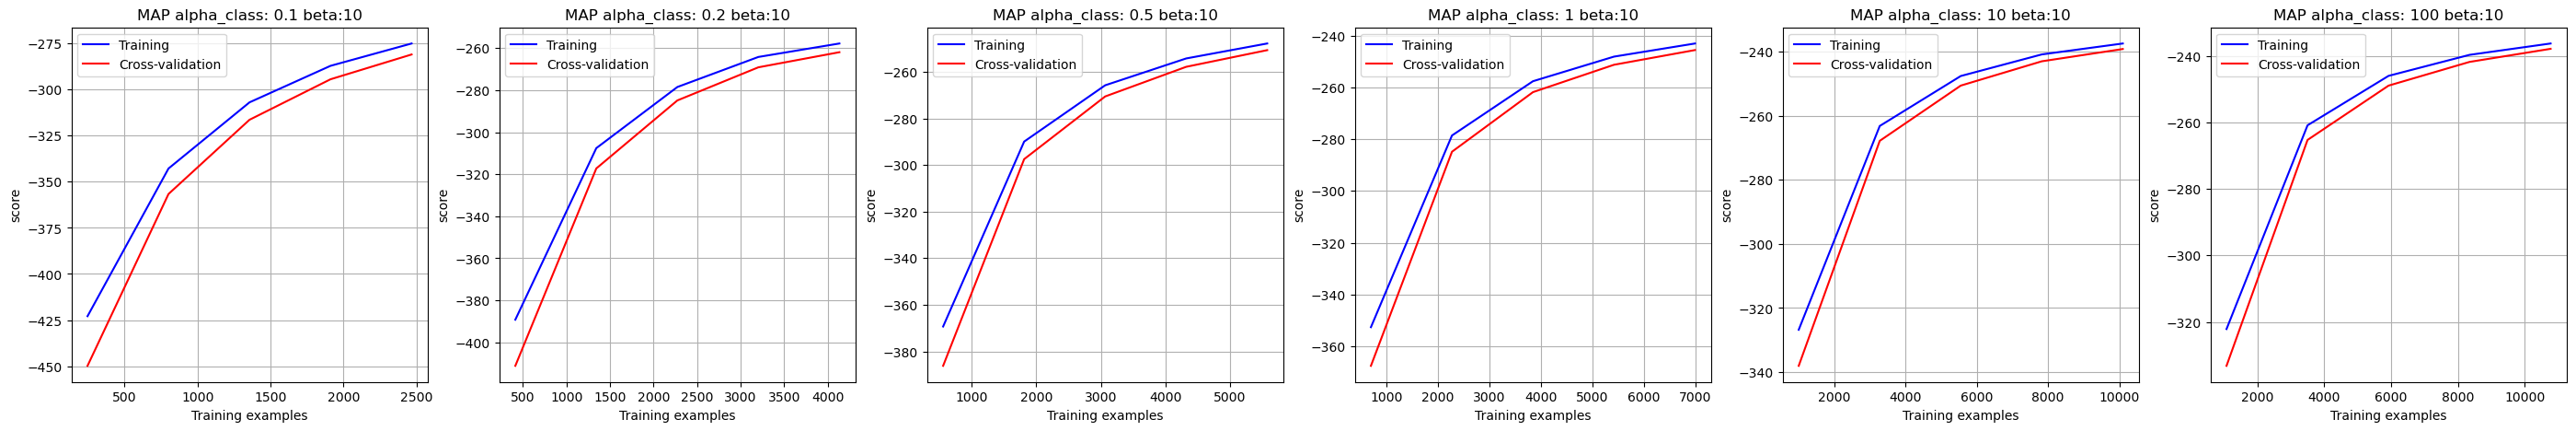

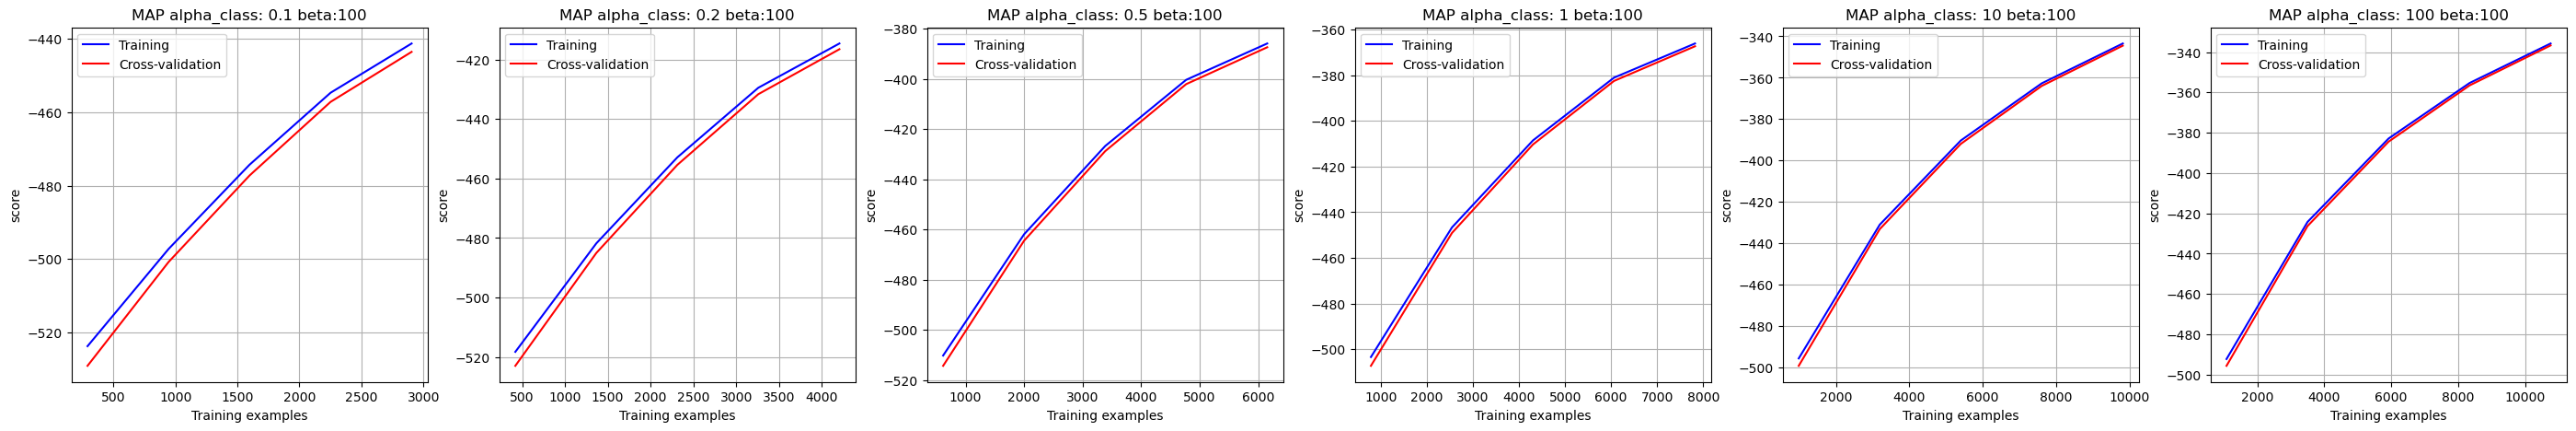

In [ ]:
import warnings
warnings.filterwarnings('ignore')
alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
betas = (1, 1.2, 2, 10, 100)
for b in (betas):
    fig, axes = plt.subplots(1, 6, figsize=(35, 5))
    axes = axes.ravel()
    for index, a_c in enumerate(alpha_class):
        data = datasets.EMNIST(
            root="~/data",
            split="balanced",
            download=True,
            transform=data_transform
        )
        X, y = get_data(data)
        cv = CustomShuffleSplit(n_splits=12, test_size=0.9, random_state=0, y=y, alpha_class=a_c)
        graph_plot_imbalance(MAP(alpha=[1] * 47, beta=[b, b]), f'MAP alpha_class: {a_c} beta:{b}', X, y, n_jobs=1, cv=cv, index=index,axes=axes)
    plt.show()

Task 5.1
### BALANCED SAMPLING


• Regarding the maximum likelihood estimation (MLE) model, it's evident from the graph that as the number of training examples increases, the score is also higher. This leads to improved performance when the size of the dataset increases.


• In the context of the MAP (Maximum A Posteriori) model, when we set the hyperparameters, namely the pixel prior (beta) and the class prior (alpha), to a value of 1, the model exhibits behavior like the MLE model.


• In the case of the MAP (Maximum A Posteriori) model, if we keep the pixel prior (beta) constant at 1 and vary the class prior (alpha), we notice that when alpha is varied, there is no noticeable difference in the model's performance compared to the MLE model.


• In the MAP model, when we keep the class prior (alpha) at 1 and play around with the pixel prior (beta) also at 1, we don't see much difference in the model's performance compared to the regular MLE model. But, if we increase beta by a small value, say to 2, the model's performance takes a big hit. This implies that our strong belief about how pixels are distributed might not be entirely correct, as it seems to negatively affect the score.


### IMBALANCED TRAINING DATA
• As the alpha_class value increases, training data also increases, resulting in a more balanced dataset. The paRerns evident in the above plots indicate a distinct trend: as alpha_class rises, the cross-validation score (red) increases, signifying improved generalization performance.
• Since MLE doesn't involve any hyperparameters, the enhancement of generalization performance (cross-validation score) occurs as alpha_class values increase.
• Generally, MAP performs beRer for higher alpha_class values in both the scenarios mentioned above.

Task 5.2

• For model deployment, MAP is the preferred choice due to its flexibility in adjusting priors and the capacity to validate assumptions. The model selection depends on the specific problem and dataset aRributes. MLE is the appropriate choice when there's a lack of prior information and ample data.